# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [15]:
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
% matplotlib inline
import seaborn as sns
import xgboost
from tqdm import tqdm
tqdm.pandas()


#import causallift
#from causallift import CausalLift


from itertools import combinations
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.utils import resample
from sklearn.model_selection import train_test_split



# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [16]:
def explore_data(df):
    
    print(str())
    
    display(df.head())
    
    display(df.shape)
    
    display(df.dtypes)
    display(np.sum(df.isnull()))
    
    display(df.describe())
    
    print("-------------------------------")


# Transcript

In [17]:
display(explore_data(transcript))

,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


(306534, 4)

person    object
event     object
value     object
time       int64
dtype: object

person    0
event     0
value     0
time      0
dtype: int64

,time
count,306534.000000
mean,366.382940
std,200.326314
min,0.000000
25%,186.000000
50%,408.000000
75%,528.000000
max,714.000000


-------------------------------


None

One column name change will be 'person' to 'id' in order to have a common column name eventually when merging with the profile column.

In [18]:
transcript = transcript.rename(columns={'person': 'id'})

transcript.head()

,id,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0


In [19]:
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

The main cleaning is the value column. It appears to be in json form, so it will need to be normalized into a flat table.

In [20]:
from pandas.io.json import json_normalize
normalized_value = json_normalize(transcript['value'])

normalized_value.head(10)

,offer id,amount,offer_id,reward
0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN,NaN
1,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
2,2906b810c7d4411798c6938adc9daaa5,NaN,NaN,NaN
3,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN,NaN
4,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN,NaN
5,f19421c1d4aa40978ebb69ca19b0e20d,NaN,NaN,NaN
6,2298d6c36e964ae4a3e7e9706d1fb8c2,NaN,NaN,NaN
7,3f207df678b143eea3cee63160fa8bed,NaN,NaN,NaN
8,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN
9,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN,NaN


In [21]:
normalized_value['offer id'].value_counts()

2298d6c36e964ae4a3e7e9706d1fb8c2    14983
fafdcd668e3743c1bb461111dcafc2a4    14924
4d5c57ea9a6940dd891ad53e9dbe8da0    14891
f19421c1d4aa40978ebb69ca19b0e20d    14835
ae264e3637204a6fb9bb56bc8210ddfd    14374
5a8bc65990b245e5a138643cd4eb9837    14305
9b98b8c7a33c4b65b9aebfe6a799e6d9    11848
3f207df678b143eea3cee63160fa8bed    11761
2906b810c7d4411798c6938adc9daaa5    11750
0b1e1539f2cc45b7b9fa7c272da2e1d7    10331
Name: offer id, dtype: int64

'offer id' and 'offer_id' columns should be merged. This can be done through the fillna pandas function.

In [22]:
normalized_value['offer_id'] = normalized_value['offer_id'].fillna(normalized_value['offer id'])
normalized_value = normalized_value.drop(columns=['offer id'], axis=1)

In [23]:
transcript = transcript.merge(normalized_value, left_index=True, right_index=True).drop(columns=['value', 'reward'], axis=1)

transcript.head()

,id,event,time,amount,offer_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,0,NaN,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,NaN,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0


In [24]:
# amount column relates to 'transaction' event value
transcript[~transcript.amount.isnull()].head()

,id,event,time,amount,offer_id
12654,02c083884c7d45b39cc68e1314fec56c,transaction,0,0.83,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,0,34.56,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,0,13.23,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,0,19.51,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,0,18.97,NaN


# Profile

In [25]:
display(explore_data(profile))

,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN


(17000, 5)

gender               object
age                   int64
id                   object
became_member_on      int64
income              float64
dtype: object

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

,age,became_member_on,income
count,17000.000000,1.700000e+04,14825.000000
mean,62.531412,2.016703e+07,65404.991568
std,26.738580,1.167750e+04,21598.299410
min,18.000000,2.013073e+07,30000.000000
25%,45.000000,2.016053e+07,49000.000000
50%,58.000000,2.017080e+07,64000.000000
75%,73.000000,2.017123e+07,80000.000000
max,118.000000,2.018073e+07,120000.000000


-------------------------------


None

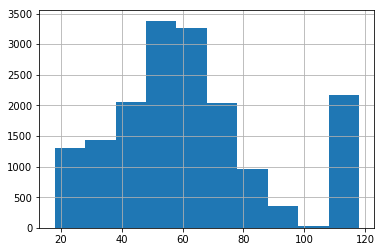

In [26]:
profile.age.hist()

The 'age' values follows a normal distribution. Missing values are encoded as 118, which explains the outlier column to the right.

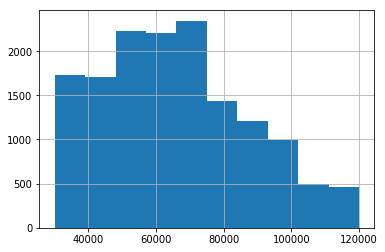

In [27]:
profile.income.hist()

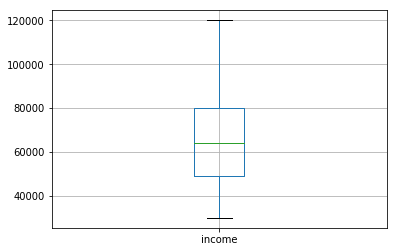

In [28]:
profile.boxplot(column=['income'])

The 'income' column doesn't have any outlier values as defined as exceeding by 1.5X the interquartile range.

The 'become_member_on' field was read in as an integer instead of a date field. This will be transformed to a 'days_as_number' field to be in a useable integer feature. This will be done by taking the time delta between today and the date associated with becoming a member.

In [29]:
from datetime import datetime, timedelta

def days_from_today(date):
        delta = datetime.today() - date

        days = delta.days

        return days

profile['became_member_on'] = profile['became_member_on'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d'))
profile['days_as_member'] = profile['became_member_on'].apply(days_from_today)

profile.head()

,gender,age,id,became_member_on,income,days_as_member
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,NaN,1014
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,861
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,NaN,499
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,928
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,NaN,841


# Portfolio

In [33]:
display(explore_data(portfolio))

,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


(10, 6)

reward         int64
channels      object
difficulty     int64
duration       int64
offer_type    object
id            object
dtype: object

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

,reward,difficulty,duration
count,10.000000,10.000000,10.000000
mean,4.200000,7.700000,6.500000
std,3.583915,5.831905,2.321398
min,0.000000,0.000000,3.000000
25%,2.000000,5.000000,5.000000
50%,4.000000,8.500000,7.000000
75%,5.000000,10.000000,7.000000
max,10.000000,20.000000,10.000000


-------------------------------


None

Notes:

The 'id' column will be renamed as 'offer-id' in order to avoid confusion with the 'id' column in the profile dataframe.

'channels' and 'offer_type' are categorical features while reward, difficulty, and duration are continuous features.

The associated channels with each offer is currently in a list format. This data will be transformed to where each channel has a column and whether or not the channel is included is included as a binary of either 0 or 1.

In [35]:
portfolio = portfolio.rename(columns={'id': 'offer_id'})


# fill null values in order to avoid error for when splitting the list into individual column values per channel        
portfolio.channels = portfolio.channels.fillna('None')

for element in ['web', 'email', 'mobile', 'social']:
    portfolio[element] = portfolio.channels.apply(lambda x: x.count(element))

portfolio = portfolio.drop(columns=['channels'], axis=1)

In [36]:
portfolio.head()

,reward,difficulty,duration,offer_type,offer_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


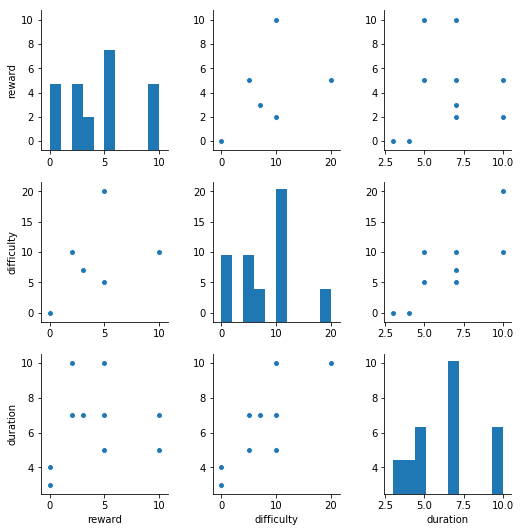

In [39]:
sns.pairplot(portfolio[['reward', 'difficulty', 'duration']]);

There appears to be some colinearity between difficulty and duration.

# Merge Dataframes

Ultimately, the three dataframe will need to be merged to do any meaningful analysis for improving outcomes.

The profile dataframe and the portfolio dataframes will merge on the 'id' column, which refers to the customer involved in the event.

The portfolio dataframe will then subsequently be merged in order to capture the characteristic of the offer for the event. This will be merged on the 'offer_id' column.

In [42]:
df = transcript.merge(profile, on='id')

df = df.merge(portfolio, on='offer_id', how='left')
    
df.head()

,id,event,time,amount,offer_id,gender,age,became_member_on,income,days_as_member,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,928,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
1,78afa995795e4d85b5d9ceeca43f5fef,offer viewed,6,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,928,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
2,78afa995795e4d85b5d9ceeca43f5fef,transaction,132,19.89,NaN,F,75,2017-05-09,100000.0,928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,78afa995795e4d85b5d9ceeca43f5fef,offer completed,132,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,100000.0,928,5.0,5.0,7.0,bogo,1.0,1.0,1.0,0.0
4,78afa995795e4d85b5d9ceeca43f5fef,transaction,144,17.78,NaN,F,75,2017-05-09,100000.0,928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Determing Treatment and Outcome values

The goal of this analysis is to eventually create an uplift model that assigns an individual an uplift score which can then be utilized to rank customers by their propensity to purchase *only* if contacted.

The events will be broken down into four segments based on the following:

_1) whether they received a treatment aka did they view an offer?_

_2) whether they ulitmately purchased aka did they have a transaction within the alotted duration of the offer?_

The 'offer viewed' event will be the indicator whether an event should be deemed in the control or treatment group. 

The two for loops below first iterate by 'id' and the iterate by each event in order to determine whether the offer was viewed during the specified duration of the offer's effectiveness.

In [89]:
id_list = df.id.unique().tolist()[:3]

for id_ in id_list:
    id_df = df.loc[df['id'].isin([id_])]
    id_df = id_df[['event', 'offer_type', 'id', 'time', 'duration', "offer_id"]].sort_values(by=['id', 'time'])
    
    id_received_df = id_df.loc[id_df['event'] == 'offer received'].reset_index()
    
    print("id: {}".format(id_))
    
    for i in range(id_received_df.shape[0]):
        offer_id = id_received_df.offer_id[i]
        offer_type = id_received_df.offer_type[i]
        time = id_received_df.time[i]
        duration = id_received_df.duration[i]
        max_time = time + duration
        timeframe = id_df.loc[(id_df['time'] >= time) & (id_df['time'] <= max_time) & (id_df['offer_id'] == offer_id)].reset_index()
        if timeframe.event.unique().tolist().count('offer viewed') > 0:
            print("YES (treatment)- {} offer received at {} was viewed".format(offer_type, time))
        else:
            print("NO (treatment) - {} offer received at {} was not reedemed".format(offer_type, time))
        if timeframe.event.unique().tolist().count('transaction') > 0:
            print("YES (outcome)- a purchase occured within the duration of {} offer received at {}".format(offer_type, time))
        else:
            print("YES (outcome)- a purchase occured within the duration of {} offer received at {}".format(offer_type, time))
        
    print("----------\n")

    
    



id: 78afa995795e4d85b5d9ceeca43f5fef
YES (treatment)- bogo offer received at 0 was viewed
YES (outcome)- a purchase occured within the duration of bogo offer received at 0
NO (treatment) - informational offer received at 168 was not reedemed
YES (outcome)- a purchase occured within the duration of informational offer received at 168
YES (treatment)- bogo offer received at 408 was viewed
YES (outcome)- a purchase occured within the duration of bogo offer received at 408
NO (treatment) - bogo offer received at 504 was not reedemed
YES (outcome)- a purchase occured within the duration of bogo offer received at 504
----------

id: a03223e636434f42ac4c3df47e8bac43
YES (treatment)- discount offer received at 0 was viewed
YES (outcome)- a purchase occured within the duration of discount offer received at 0
YES (treatment)- informational offer received at 336 was viewed
YES (outcome)- a purchase occured within the duration of informational offer received at 336
NO (treatment) - informational o

In [87]:
timeframe

,index,event,offer_type,id,time,duration,offer_id
0,148,offer received,discount,31dda685af34476cad5bc968bdb01c53,576,10.0,fafdcd668e3743c1bb461111dcafc2a4
1,149,offer viewed,discount,31dda685af34476cad5bc968bdb01c53,582,10.0,fafdcd668e3743c1bb461111dcafc2a4


The cell above is an example of a timeframe where a treatment occurs. The 'offer viewed' event happens within the duration of the 'offer received' on time 576.

The set_treatment_outcome() function in the process_data.py file applies this approach to the entire dataframe. 
There are drawbacks to this approach. The for loops are CPU intensive due to the calculations being done and are memory intensive for the assignments. Future work can be done to refactor the code to reduce the reliance on for loops.

/end